In [1]:
import sys
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
# plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 18,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )
# mpl.rcParams.update(
#     {'font.size': 18,
#      'font.family': 'sans-serif',
#      'font.sans-serif': ['Helvetica'],
#      'legend.fontsize': 14,
#      'axes.labelsize': 18,
#      'xtick.labelsize': 14,
#      'ytick.labelsize': 14
#     }
#     )
# mpl.rcParams

['/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-e1651/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packa

In [14]:
from processing import lumi_periods_2017, lumi_periods_2018

lepton_type = 'muon'
# lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


### Event selection

In [9]:
def select_events( df_events, lepton_type, max_num_tracks = -1, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
    deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
#     msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
#                  ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    
    msk_tau21_       = ( jet0_tau21_ <= 0.60 )
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
    
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )

#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )    
    msk_extra_tracks_ = None
    if max_num_tracks_ >= 0:
        msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    else:
        msk_extra_tracks_ = np.full( df_events.shape[0], True, dtype=bool )
    
    masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### MC (Bkg)

In [4]:
load_MC = True

labels_MC = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC = [ ]
    elif lepton_type == 'electron':
        labels_MC = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC = [ "Bkg-2018-muon-TTJets" ]
    elif lepton_type == 'electron':
        labels_MC = [ "Bkg-2018-electron-TTJets" ]
    
df_counts_MC = {}
df_events_MC = {}
if load_MC:
    base_path_ = "output"
    for label_ in labels_MC:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_MC[ label_ ] = store_[ "counts" ]
            df_events_MC[ label_ ] = store_[ "events" ]

Bkg-2018-muon-TTJets
['/counts', '/events']


In [18]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = ''
    elif lepton_type == 'electron':
        label_ref_ = ''
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'Bkg-2018-muon-TTJets'
    elif lepton_type == 'electron':
        label_ref_ = 'Bkg-2018-electron-TTJets'
df_events_MC[ label_ref_ ]

print ( df_events_MC[ label_ref_ ].columns.values )

['run' 'lumiblock' 'event' 'crossingAngle' 'betaStar' 'instLumi' 'jet0_pt'
 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'jet0_px' 'jet0_py' 'jet0_pz'
 'calo_met' 'met' 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8'
 'num_bjets_ak4' 'num_jets_ak4' 'pfcand_nextracks'
 'pfcand_nextracks_noDRl' 'recoMWhad' 'recoMWlep' 'recoMWW'
 'recoRapidityWW' 'dphiWW' 'WLeptonicPt' 'WLeptonicEta' 'WLeptonicPhi'
 'muon0_pt' 'muon0_eta' 'muon0_phi' 'muon0_energy' 'muon0_charge'
 'muon0_iso' 'muon0_dxy' 'muon0_dz' 'muon0_trackerLayersWithMeasurement'
 'run_mc' 'pileupWeight' 'mc_pu_trueinteractions' 'mcWeight'
 'prefiring_weight' 'prefiring_weight_up' 'prefiring_weight_down'
 'prefiring_weight_ECAL' 'prefiring_weight_ECAL_up'
 'prefiring_weight_ECAL_down' 'prefiring_weight_Muon'
 'prefiring_weight_Muon_up' 'prefiring_weight_Muon_down' 'jet0_jer_res'
 'jet0_jer_sf' 'jet0_jer_sfup' 'jet0_jer_sfdown' 'jet0_cjer'
 'jet0_cjer_up' 'jet0_cjer_down

In [6]:
labels_samples = {
    "Bkg-2018-muon-TTJets": r"$t \bar{t} + \rm{jets}$",
    "Bkg-2018-electron-TTJets": r"$t \bar{t} + \rm{jets}$",
}

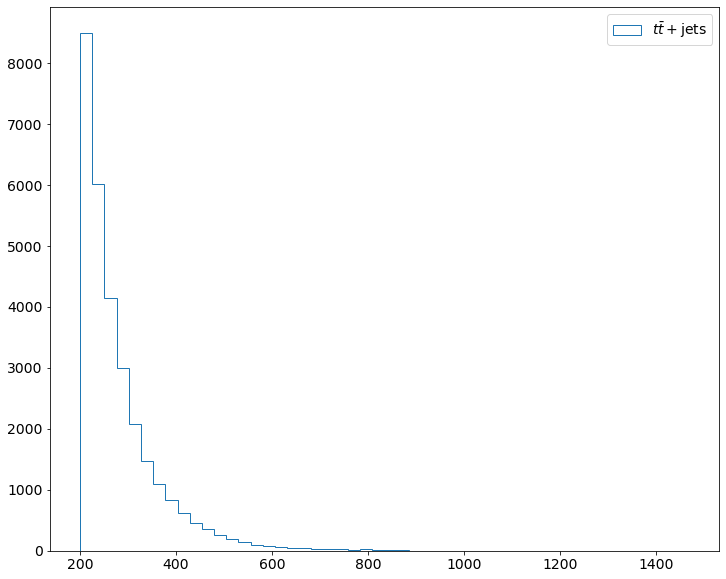

In [7]:
var__ = "jet0_pt_nom"
if load_MC:
    fig = plt.figure( figsize=(12,10) )
    for label__ in labels_MC: 
        plt.hist( df_events_MC[ label__ ][ var__ ], histtype='step', density=False, bins=50, label=labels_samples[ label__ ] )
    plt.legend( loc='best', fontsize=14 )

### Select events

In [10]:
df_selected_events_MC = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw", "_jer_up", "_jer_dw" ] }
for label__ in labels_MC:
    print ( label__ )
    df_events__ = df_events_MC[ label__ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__, lepton_type )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_selected_events_MC[ label__ ] = {}
    df_selected_events_MC[ label__ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__  = select_events( df_events__, lepton_type, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_selected_events_MC[ label__ ][ variation__ ] = df_selected_events__

Bkg-2018-muon-TTJets
29673
2198
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 29673, 'Muon': 29635, 'Jet': 22720, 'Jet_Muon': 22193, 'MET': 18909, 'Jet_MET': 16461, 'PrunedMass': 8289, 'Tau21': 6964, 'BJet_Veto': 4069, 'Xi_CMS': 3771, 'WLeptonic': 2381, 'Jet_WLeptonic': 2317, 'MWW': 2198, 'ExtraTracks': 2198}
jet
{'label_jet': '_jes_up'}
2193
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 29673, 'Muon': 29635, 'Jet': 23433, 'Jet_Muon': 22876, 'MET': 19451, 'Jet_MET': 16903, 'PrunedMass': 8472, 'Tau21': 7104, 'BJet_Veto': 4149, 'Xi_CMS': 3833, 'WLeptonic': 2391, 'Jet_WLeptonic': 2326, 'MWW': 2193, 'ExtraTracks': 2193}
{'label_jet': '_jes_dw'}
2185
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLe

In [26]:
df_selected_events_MC

{'Bkg-2018-muon-TTJets': {'_nom':        run  lumiblock     event  crossingAngle  betaStar  instLumi  \
  3        1         45    173501          140.0       0.0       0.0   
  12       1         46    177454          140.0       0.0       0.0   
  27       1        351   1364877          140.0       0.0       0.0   
  42       1        773   3003524          140.0       0.0       0.0   
  46       1        774   3006527          140.0       0.0       0.0   
  ...    ...        ...       ...            ...       ...       ...   
  29540    1       9236  35918300          140.0       0.0       0.0   
  29566    1       9302  36175376          140.0       0.0       0.0   
  29577    1       9383  36490376          140.0       0.0       0.0   
  29656    1       8895  34592448          140.0       0.0       0.0   
  29667    1       9123  35476220          140.0       0.0       0.0   
  
            jet0_pt  jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_56_nom  \
  3      243.563309  0.200

In [16]:
import json
samples_info = json.load( open( 'samples_info_UL.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [100000.0, 0.058313, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [100000.0, 0.049199, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [100000.0, 0.148122, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_8e-6_semi_pt0': [100000.0, 0.061404, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 0.0409705, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [100000.0, 0.045393, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [99000.0, 0.16477, 1.0, 6],
 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8': [3228512.0, 831.76, 1.0, 800]}

In [15]:
sample_names = {}
if data_sample == '2017':
    pass
elif data_sample == '2018':
    sample_names[ "Bkg-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'

In [17]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )
    
norm_factors = {}
for label__ in labels_MC:
    print ( label__ )
    print ( samples_info[ sample_names[ label__ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label_ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
#     if norm_to_1fb:
#         sample_cross_section_ = 1.e-03
    print ( sample_cross_section_ )
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    
    df_selected_events_MC[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_selected_events_MC[ label__ ]:
        print ( variation__ )
        df_selected_events_MC[ label__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

59.76559325367668
Bkg-2018-muon-TTJets
[3228512.0, 831.76, 1.0, 800]
831.76
[1.85118077e-05 8.31760000e+05 1.00000000e+00]
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [20]:
var_name__ = ""
if lepton_type == 'muon':
    var_name__ = "sf_muon_id"
elif lepton_type == 'electron':
    var_name__ = "sf_electron_id"
var_name_up__ = var_name__ + "_up"
var_name_dw__ = var_name__ + "_dw"

df_selected_events_MC[ "Bkg-2018-muon-TTJets" ][ "_nom" ][ [ var_name__, var_name_up__, var_name_dw__ ] ]

,sf_muon_id,sf_muon_id_up,sf_muon_id_dw
3,0.996643,0.997023,0.996263
12,0.996095,0.996925,0.995265
27,0.995787,0.996356,0.995218
42,0.996643,0.997023,0.996263
46,0.996095,0.996925,0.995265
...,...,...,...
29540,0.996446,0.997184,0.995708
29566,0.996095,0.996925,0.995265
29577,0.996643,0.997023,0.996263
29656,0.995787,0.996356,0.995218


In [21]:
df_selected_events_MC[ "Bkg-2018-muon-TTJets" ][ "_nom" ][ [ "pileupWeight" ] ]

,pileupWeight
3,0.980164
12,1.037180
27,1.109821
42,1.005129
46,0.894665
...,...
29540,1.011660
29566,1.005129
29577,1.109821
29656,0.856406


In [23]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )

var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )

weights_events_MC = {}
for label__ in labels_MC:
    print ( label__ )
    
    weights_events_MC[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_MC[ label_ ][ var_weights__ ] = {}
        for variation__ in df_selected_events_MC[ label__ ]:
            df_selected_events__ = df_selected_events_MC[ label__ ][ variation__ ]
            weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                             df_selected_events__[ "pileupWeight" ] *
                                                                             df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ] )

print ( weights_events_MC )

['nom', 'sf_muon_id_up', 'sf_muon_id_dw']
{'nom': 'sf_muon_id', 'sf_muon_id_up': 'sf_muon_id_up', 'sf_muon_id_dw': 'sf_muon_id_dw'}
Bkg-2018-muon-TTJets
{'Bkg-2018-muon-TTJets': {'nom': {'_nom': 3        15.041288
12       15.907491
27       17.016349
42       15.424388
46       13.721696
           ...    
29540    15.521559
29566    15.415910
29577    17.030968
29656    13.130864
29667    15.666096
Length: 2198, dtype: float64, '_jes_up': 3        15.041288
12       15.907491
27       17.016349
42       15.424388
46       13.721696
           ...    
29540    15.521559
29566    15.415910
29577    17.030968
29656    13.130864
29667    15.666096
Length: 2193, dtype: float64, '_jes_dw': 3        15.041288
12       15.907491
27       17.016349
46       13.721696
54       15.318489
           ...    
29540    15.521559
29566    15.415910
29577    17.030968
29656    13.130864
29667    15.666096
Length: 2185, dtype: float64, '_jer_up': 3        15.041288
12       15.907491
27       17.01634

### Plot MC

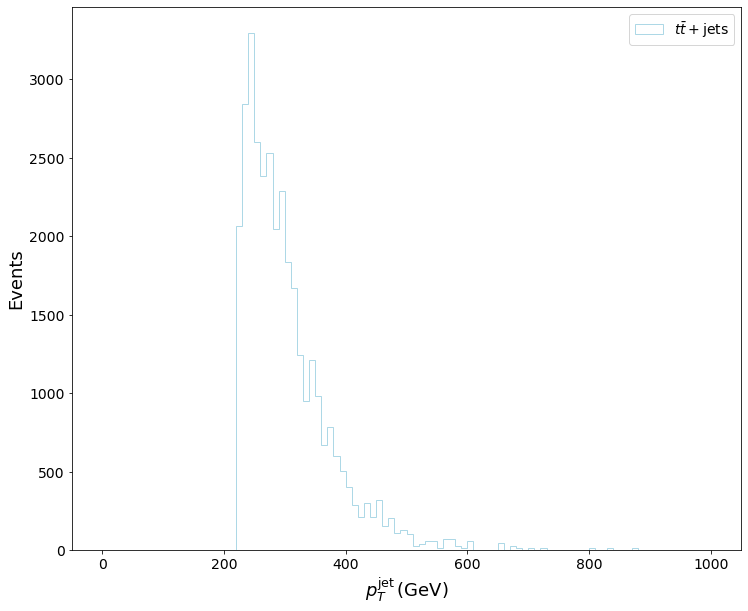

In [35]:
fig = plt.figure( figsize=(12,10) )

variation__ = "_nom"
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]

linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

range_ = (0., 1000.) 
bins_ = 100

for idx__, label__ in enumerate( labels_MC ):
    plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ "jet0_pt" + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )

plt.xlabel( r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $", fontsize=18 )
plt.ylabel( "Events", fontsize=18 )
plt.legend( loc='best', fontsize=14 )

### Data

In [27]:
labels_data = []
fileNames_data = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_data = [ ]
        fileNames_data = {
            
        }
    elif lepton_type == 'electron':
        labels_data = [ ]
        fileNames_data = {
            
        }
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_data = [
            "data-2018-muon-2018A",
            "data-2018-muon-2018B",
            "data-2018-muon-2018C",
            "data-2018-muon-2018D"
        ]
        fileNames_data = {
            "data-2018-muon-2018A": "data-store-data-2018-muon-2018A.h5",
            "data-2018-muon-2018B": "data-store-data-2018-muon-2018B.h5",
            "data-2018-muon-2018C": "data-store-data-2018-muon-2018C.h5",
            "data-2018-muon-2018D": "data-store-data-2018-muon-2018D.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [
            "data-2018-electron-2018A",
            "data-2018-electron-2018B",
            "data-2018-electron-2018C",
            "data-2018-electron-2018D"
        ]
        fileNames_data = {
            "data-2018-electron-2018A": "data-store-data-2018-electron-2018A.h5",
            "data-2018-electron-2018B": "data-store-data-2018-electron-2018B.h5",
            "data-2018-electron-2018C": "data-store-data-2018-electron-2018C.h5",
            "data-2018-electron-2018D": "data-store-data-2018-electron-2018D.h5"
        }

base_path_ = 'output'
for label_ in fileNames_data:
    fileNames_data[ label_ ] = "{}/{}".format( base_path_, fileNames_data[ label_ ] )
print ( fileNames_data )

df_counts_data = None
df_events_data = None

df_counts_data_list_ = []
df_events_data_list_ = []
for label__ in labels_data:
    print ( label__ )
    file_path_ = fileNames_data[ label__ ]
    print ( file_path_ )
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        
        df_counts_data__ = store_[ "counts" ]
        df_events_data__ = store_[ "events" ]
        df_counts_data_list_.append( df_counts_data__ )
        df_events_data_list_.append( df_events_data__ )

df_counts_data = df_counts_data_list_[0]
for idx_ in range( 1, len( df_counts_data_list_ ) ):
    df_counts_data = df_counts_data.add( df_counts_data_list_[ idx_ ] )

df_events_data = pd.concat( df_events_data_list_ )

{'data-2018-muon-2018A': 'output/data-store-data-2018-muon-2018A.h5', 'data-2018-muon-2018B': 'output/data-store-data-2018-muon-2018B.h5', 'data-2018-muon-2018C': 'output/data-store-data-2018-muon-2018C.h5', 'data-2018-muon-2018D': 'output/data-store-data-2018-muon-2018D.h5'}
data-2018-muon-2018A
output/data-store-data-2018-muon-2018A.h5
['/counts', '/events']
data-2018-muon-2018B
output/data-store-data-2018-muon-2018B.h5
['/counts', '/events']
data-2018-muon-2018C
output/data-store-data-2018-muon-2018C.h5
['/counts', '/events']
data-2018-muon-2018D
output/data-store-data-2018-muon-2018D.h5
['/counts', '/events']


In [28]:
df_counts_data

All           2168978
Jet           2168978
Muon          2101524
check_none    2101524
dtype: int64

In [29]:
df_events_data

,run,lumiblock,event,crossingAngle,betaStar,instLumi,jet0_pt,jet0_eta,jet0_phi,jet0_energy,...,WLeptonicPy_nom,WLeptonicPz_nom,WLeptonicE_nom,WLeptonicM_nom,WW_energy_nom,WW_pz_nom,MWW_nom,YWW_nom,xiCMS_45_nom,xiCMS_56_nom
0,315488,496,475180672,150.0,0.3,10.037100,324.418854,-1.745987,-2.374501,962.026794,...,266.945923,-255.383423,403.616882,80.380127,1365.643677,-1156.794678,718.714417,-1.245685,0.015135,0.193103
1,315488,496,474492736,150.0,0.3,10.037100,254.027451,-1.322386,0.040865,515.584961,...,76.241447,232.864914,318.975616,80.380272,834.560547,-209.887894,800.355713,-0.257008,0.046865,0.079155
2,315488,496,474879328,150.0,0.3,10.037100,277.950073,-1.939334,0.408438,991.736572,...,-82.667419,-114.833130,254.945709,88.454399,1246.682251,-1061.297363,650.545715,-1.260847,0.012634,0.175911
3,315488,496,474548640,150.0,0.3,10.037100,430.706177,-1.419859,3.136551,958.454407,...,43.376720,131.947021,236.058884,80.380089,1194.513306,-706.807861,926.748779,-0.680296,0.035232,0.143972
4,315488,496,474906016,150.0,0.3,10.037100,234.374908,1.846084,2.145988,764.282471,...,-80.876724,457.071960,504.337677,80.379959,1268.620117,1180.951904,445.618256,1.665055,0.187671,0.005986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113877,325170,638,1175818880,133.0,0.3,9.299241,240.912888,0.785956,0.338386,323.060333,...,-70.913414,475.830414,554.740601,179.506393,877.800903,685.282349,548.215698,1.047112,0.117647,0.012219
113878,325170,646,1189408128,133.0,0.3,9.256189,244.522369,0.625718,-0.854012,307.663757,...,-34.330780,136.071136,194.756897,80.380089,502.420654,299.254395,335.163116,0.686339,0.059279,0.013240
113879,325170,646,1189031680,133.0,0.3,9.256189,280.787811,0.224587,0.903871,302.975403,...,-217.282745,28.342747,239.183044,80.380081,542.158447,91.935547,520.318115,0.171227,0.046547,0.032403
113880,325170,646,1189169920,133.0,0.3,9.256189,281.083374,1.122923,-0.892913,483.484070,...,106.177147,134.274094,203.753601,80.380150,687.237671,520.552673,422.513092,0.990221,0.091193,0.011108


### Select events

In [30]:
df_events_data__, selection_keys_, selections_ = select_events( df_events_data, lepton_type )
df_events_data = df_events_data__
print ( df_events_data.shape[0] )
print ( selection_keys_ )
print ( selections_ )

81307
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2101524, 'Muon': 2098271, 'Jet': 1502978, 'Jet_Muon': 1484114, 'MET': 1151529, 'Jet_MET': 1032122, 'PrunedMass': 284410, 'Tau21': 190848, 'BJet_Veto': 152257, 'Xi_CMS': 134927, 'WLeptonic': 88552, 'Jet_WLeptonic': 86362, 'MWW': 81307, 'ExtraTracks': 81307}


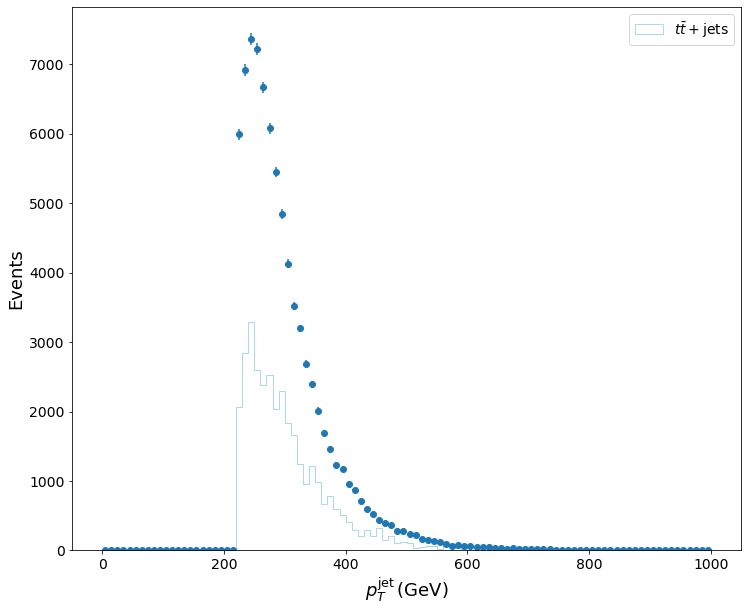

In [36]:
fig = plt.figure( figsize=(12,10) )

variation__ = "_nom"
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]

linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

range_ = (0., 1000.) 
bins_ = 100

counts_bins_, bin_edges_ = np.histogram( df_events_data[ "jet0_pt" ], range=range_, bins=bins_ )
errors_bins_ = np.sqrt( counts_bins_ )
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
plt.errorbar( bin_centres_, counts_bins_, yerr=errors_bins_, fmt='o')

for idx__, label__ in enumerate( labels_MC ):
    plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ "jet0_pt" + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )

plt.xlabel( r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $", fontsize=18 )
plt.ylabel( "Events", fontsize=18 )
plt.legend( loc='best', fontsize=14 )